# Impact of the geometry on HPL performance

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
warnings.simplefilter(action='ignore') # removing annoying Pandas warning

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_result(name):
    archive = zipfile.ZipFile(name)
    df = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    df['filename'] = name
    return df

directory = 'geometry/1'
archives = [os.path.join(directory, f) for f in os.listdir(directory)]

df = pandas.concat([read_result(a) for a in archives])
df['geometry'] = df['proc_p'].astype(str) + '×' + df['proc_q'].astype(str)
df.head()

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process,time,gflops,residual,start_timestamp,stop_timestamp,filename,geometry
0,100000,512,2,30,1,2,2,1,0,8,1,18,79.01,8438.0,1.242904e+08,2020-06-16 19:24:39.762137,2020-06-16 19:26:09.598088,geometry/1/nancy_2020-06-16_2620305.zip,2×30
1,300000,512,4,15,1,2,2,1,0,8,1,18,902.91,19940.0,7.565128e+06,2020-06-16 19:26:16.167085,2020-06-16 19:42:45.838273,geometry/1/nancy_2020-06-16_2620305.zip,4×15
2,200000,512,5,12,1,2,2,1,0,8,1,18,315.22,16920.0,2.629932e+07,2020-06-16 19:42:47.355465,2020-06-16 19:48:41.368115,geometry/1/nancy_2020-06-16_2620305.zip,5×12
3,300000,512,1,60,1,2,2,1,0,8,1,18,1369.49,13140.0,NaN,2020-06-16 19:48:42.874186,2020-06-16 20:13:00.403126,geometry/1/nancy_2020-06-16_2620305.zip,1×60
4,300000,512,3,20,1,2,2,1,0,8,1,18,975.80,18450.0,7.551262e+06,2020-06-16 20:13:01.997665,2020-06-16 20:30:45.653799,geometry/1/nancy_2020-06-16_2620305.zip,3×20


### Checking the parameters

In [2]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm', 'platform', 'model', 'filename',
                   'simulation', 'slow_nodes',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode',
                   'start_timestamp', 'stop_timestamp'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,mem_align,proc_q,block_size,depth,geometry,thread_per_process,pfact,process_per_node,swap,proc_p,bcast,rfact
0,8,30,512,1,2×30,18,1,1,0,2,2,2
1,8,15,512,1,4×15,18,1,1,0,4,2,2
2,8,12,512,1,5×12,18,1,1,0,5,2,2
3,8,60,512,1,1×60,18,1,1,0,1,2,2
4,8,20,512,1,3×20,18,1,1,0,3,2,2
7,8,10,512,1,6×10,18,1,1,0,6,2,2
13,8,6,512,1,10×6,18,1,1,0,10,2,2


## HPL performance

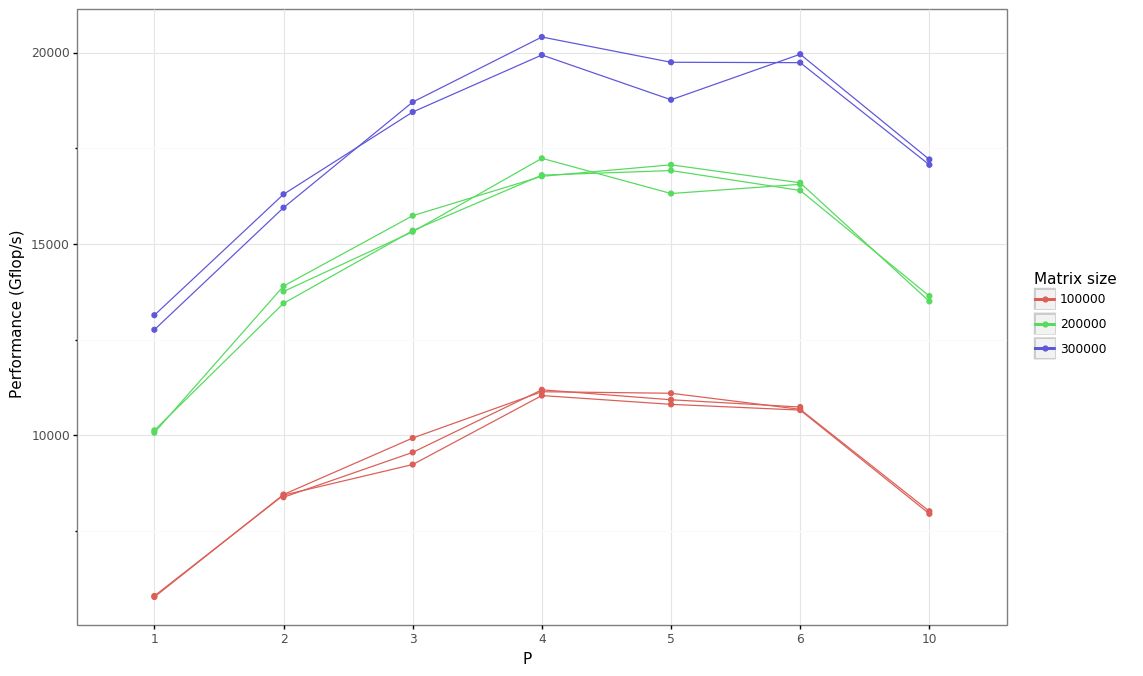

<ggplot: (-9223363282112127628)>

In [3]:
df['group'] = df['filename'] + ':' + df['matrix_size'].astype(str)
(ggplot(df)
    + aes(x='factor(proc_p)', y='gflops', color='factor(matrix_size)', group='group')
    + geom_point()
#    + geom_text(aes(label='geometry'), position=position_nudge(y=200))
    + geom_line()
    + theme_bw()
    + labs(x='P', y='Performance (Gflop/s)', color='Matrix size')
)